<a href="https://colab.research.google.com/github/Saikowshik007/AI_Job_Predictor/blob/master/CNN_Best_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Embedding, LSTM
from keras.layers.core import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
from keras import metrics, regularizers
from keras.preprocessing import sequence
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
#Load cleaned dataset
from google.colab import drive
drive.mount("/content/gdrive")
data = pd.read_csv('/content/gdrive/My Drive/dataset/sample.csv', header = 0, names = ['Query', 'Description'],encoding="utf-8-sig")

Mounted at /content/gdrive


In [ ]:
#Split the dataset to Training and Test subsets (90/10)
train, test = train_test_split(data, test_size = 0.01, random_state = 17)

train_descs = train['Description'].astype("str")
train_labels = train['Query'].astype("str")
 
test_descs = test['Description'].astype("str")
test_labels = test['Query'].astype("str")

In [ ]:
# Model Parameters
vocab_size = 1000

sequences_length = 1200

embedding_dimensionality = 64 
max_features = 2000 #equal to vocab_size

num_labels = len(train_labels.unique())
batch_size = 32
nb_epoch = 20

nof_filters = 200
kernel_size = 16

hidden_dims = 512

In [ ]:
# Convert Texts to Numeric Vectors for Input
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(train_descs)

x_train = tokenizer.texts_to_sequences(train_descs)
x_test = tokenizer.texts_to_sequences(test_descs)

x_train = sequence.pad_sequences(x_train, maxlen = sequences_length, padding = 'post')
x_test = sequence.pad_sequences(x_test, maxlen = sequences_length, padding = 'post')

encoder = LabelBinarizer()
encoder.fit(train_labels)
y_train = encoder.transform(train_labels)
y_test = encoder.transform(test_labels)

In [ ]:
model = Sequential()
model.add(Embedding(max_features, embedding_dimensionality, input_length = 1200))

model.add(Conv1D(nof_filters, kernel_size, padding='valid', activation='relu', strides = 1))
model.add(GlobalMaxPooling1D())

model.add(Dense(hidden_dims))
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', #'sgd', 'adam', 'RMSprop', 'Adagrad'
                   metrics = [metrics.categorical_accuracy])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1200, 64)          128000    
_________________________________________________________________
conv1d (Conv1D)              (None, 1185, 200)         205000    
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               102912    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = nb_epoch,
                    verbose = True,
                    validation_split = 0.01)

Epoch 1/20
536/536 [==============================] - 43s 20ms/step - loss: 2.3679 - categorical_accuracy: 0.2937 - val_loss: 0.4470 - val_categorical_accuracy: 0.8563
Epoch 2/20
536/536 [==============================] - 10s 18ms/step - loss: 0.3733 - categorical_accuracy: 0.8832 - val_loss: 0.2505 - val_categorical_accuracy: 0.9310
Epoch 3/20
536/536 [==============================] - 10s 18ms/step - loss: 0.2136 - categorical_accuracy: 0.9342 - val_loss: 0.2508 - val_categorical_accuracy: 0.9138
Epoch 4/20
536/536 [==============================] - 10s 19ms/step - loss: 0.1669 - categorical_accuracy: 0.9487 - val_loss: 0.2131 - val_categorical_accuracy: 0.9368
Epoch 5/20
536/536 [==============================] - 10s 19ms/step - loss: 0.1492 - categorical_accuracy: 0.9545 - val_loss: 0.1755 - val_categorical_accuracy: 0.9368
Epoch 6/20
536/536 [==============================] - 10s 18ms/step - loss: 0.1335 - categorical_accuracy: 0.9590 - val_loss: 0.2344 - val_categorical_accuracy:

In [ ]:
score = model.evaluate(x_test, y_test, batch_size = batch_size, verbose = True)
 
print('\nTest categorical_crossentropy:', score[0])
print('Categorical accuracy:', score[1])


6/6 [==============================] - 0s 11ms/step - loss: 0.3182 - categorical_accuracy: 0.9086

Test categorical_crossentropy: 0.3182375729084015
Categorical accuracy: 0.9085714221000671


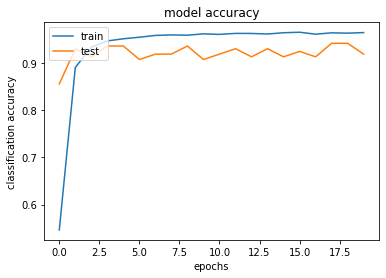

In [ ]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('classification accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save( '/content/gdrive/My Drive/dataset/model-cnn.h5' )

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/gdrive/My Drive/dataset/model-cnn.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("/content/gdrive/My Drive/dataset/converted_model-cnn.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpm31jerkj/assets


1798364

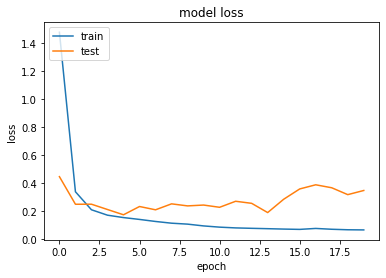

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
text=input()
try:
    predict=model.predict(tokenizer.texts_to_sequences([text]))
    print(predict)
    print(encoder.inverse_transform(predict))
    print(predict.argmax(axis=-1))
except:
    print("Invalid Input")

4/1AY0e-g68DL9zYlqFhxB7VXpVrTgtLXYlFaemLvu028nL8bKBhKcH8_QMAmE


Invalid Input


In [ ]:
import json

with open( '/content/gdrive/My Drive/dataset/dict.json' , 'w' ) as file:
    json.dump( tokenizer.word_index , file )


In [ ]:
import tensorflow as tf
interpreter = tf.lite.Interpreter("/content/gdrive/My Drive/dataset/converted_model-cnn.tflite")

In [ ]:
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
output_details

[{'dtype': numpy.float32,
  'index': 19,
  'name': 'Identity',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([ 1, 25], dtype=int32),
  'shape_signature': array([-1, 25], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
input_details

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'embedding_input',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([   1, 1200], dtype=int32),
  'shape_signature': array([  -1, 1200], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
tf.version

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>

In [ ]:
import tensorflow as tf
from google.colab import drive
drive.mount("/content/gdrive")
interpreter = tf.lite.Interpreter(model_path="/content/gdrive/My Drive/dataset/converted_model-cnn.tflite")
interpreter.allocate_tensors()

# Print input shape and type
inputs = interpreter.get_input_details()
print('{} input(s):'.format(len(inputs)))
for i in range(0, len(inputs)):
    print('{} {}'.format(inputs[i]['shape'], inputs[i]['dtype']))

# Print output shape and type
outputs = interpreter.get_output_details()
print('\n{} output(s):'.format(len(outputs)))
for i in range(0, len(outputs)):
    print('{} {}'.format(outputs[i]['shape'], outputs[i]['dtype']))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
1 input(s):
[   1 1200] <class 'numpy.float32'>

1 output(s):
[ 1 25] <class 'numpy.float32'>
